# Printing and Plotting Results

Contains two sections:
1. How to create a summary table.
2. How to create plots showing the ranks of the similarity measures.

## Summary Table

This section of the notebook, creates the overview table in our paper. This code can be easily adjusted to also output more detailed tables.

In [47]:
import re
from pathlib import Path

import pandas as pd
import pandas.io.formats.style

import matplotlib.pyplot as plt

from repsim.benchmark.paths import BASE_PATH


measure_to_abbrv = {
    "AlignedCosineSimilarity": "AlignCos",
    "CKA": "CKA",
    "ConcentricityDifference": "ConcDiff",
    "DistanceCorrelation": "DistCorr",
    "EigenspaceOverlapScore": "EOS",
    "GeometryScore": "GS",
    "Gulp": "GULP",
    "HardCorrelationMatch": "HardCorr",
    "IMDScore": "IMD",
    "JaccardSimilarity": "Jaccard",
    "LinearRegression": "LinReg",
    "MagnitudeDifference": "MagDiff",
    "OrthogonalAngularShapeMetricCentered": "AngShape",
    "OrthogonalProcrustesCenteredAndNormalized": "OrthProc",
    "PWCCA": "PWCCA",
    "PermutationProcrustes": "PermProc",
    "ProcrustesSizeAndShapeDistance": "ProcDist",
    "RSA": "RSA",
    "RSMNormDifference": "RSMDiff",
    "RankSimilarity": "RankSim",
    "SVCCA": "SVCCA",
    "SecondOrderCosineSimilarity": "2nd-Cos",
    "SoftCorrelationMatch": "SoftCorr",
    "UniformityDifference": "UnifDiff"
}

measure_types = [
    ("AlignCos", "Alignment"),
    ("HardCorr", "Alignment"),
    ("AngShape", "Alignment"),
    ("LinReg", "Alignment"),
    ("OrthProc", "Alignment"),
    ("PermProc", "Alignment"),
    ("ProcDist", "Alignment"),
    ("SoftCorr", "Alignment"),

    ("EOS", "RSM"),
    ("CKA", "RSM"),
    ("DistCorr", "RSM"),
    ("GULP", "RSM"),
    ("RSA", "RSM"),
    ("RSMDiff", "RSM"),

    ("MagDiff", "Statistic"),
    ("ConcDiff", "Statistic"),
    ("UnifDiff", "Statistic"),

    ("GS", "Topology"),
    ("IMD", "Topology"),

    ("Jaccard", "Neighbors"),
    ("RankSim", "Neighbors"),
    ("2nd-Cos", "Neighbors"),

    ("PWCCA", "CCA"),
    ("SVCCA", "CCA"),

]


Step 1: Load all results.

In [33]:
cleaned_dfs = []
nlp_root = BASE_PATH /"paper_results" / "nlp"
for path in nlp_root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    setting = path.name.split("_")[0]

    pattern = r'(?<=_)sst2(?=_)|(?<=_)mnli(?=_)'
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
nlp_data = data


In [34]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"graph"
for path in root.glob("*.csv"):
    if path.name.endswith("backup.csv"):
        continue

    df = pd.read_csv(path, index_col=0)
    pattern = r"augmentation|label_test|layer_test|output_correlation|shortcut"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "augmentation": "aug",
        "label_test": "mem",
        "layer_test": "mono",
        "output_correlation": "correlation",
        "shortcut": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)cora(?=_)|(?<=_)flickr(?=_)|(?<=_)ogbn-arxiv(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
graph_data = data

In [35]:
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr")].groupby(["architecture", "functional_similarity_measure","similarity_measure"]).count()
graph_data[(graph_data.representation_dataset=="cora") & (graph_data.Setting == "correlation") & (graph_data.quality_measure == "spearmanr") & (graph_data.similarity_measure == "AlignedCosineSimilarity") & (graph_data.architecture == "GCN")]

,similarity_measure,quality_measure,model,value,domain,architecture,representation_dataset,identifier,Setting,Dataset,functional_similarity_measure,corr,pval
799,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,JSD,0.016601,0.9142
802,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,Disagreement,-0.084083,0.5792
805,AlignedCosineSimilarity,spearmanr,NaN,NaN,GRAPHS,GCN,cora,Normal,correlation,cora,AbsoluteAccDiff,-0.331839,0.0244


In [36]:
cleaned_dfs = []
root = BASE_PATH /"paper_results" /"vision"
for path in root.glob("*.csv"):
    df = pd.read_csv(path, index_col=0)
    pattern = r"aug|mem|mono|correlation|sc"
    match = re.search(pattern, path.name)
    pattern_to_setting = {
        "aug": "aug",
        "mem": "mem",
        "mono": "mono",
        "correlation": "correlation",
        "sc": "sc",
    }
    setting = pattern_to_setting[match.group(0)]

    pattern = r"(?<=_)in100(?=_)"
    match = re.search(pattern, path.name)
    assert match is not None
    dataset = match.group(0)

    df["Setting"] = setting
    df["Dataset"] = dataset
    cleaned_dfs.append(df)

data = pd.concat(cleaned_dfs).reset_index(drop=True)
vision_data = data

## Clean and Pivot

Step 2: Combine data into a big dataframe, clean up column names etc., and select data to be shown in table.

In [37]:
# ----------------------------------------------------------------------------------------------------------------------
# Combine data
# ----------------------------------------------------------------------------------------------------------------------
data = pd.concat([nlp_data, graph_data, vision_data])
print(data.columns)

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

# ----------------------------------------------------------------------------------------------------------------------
# Exclude data not to be shown in table.
# ----------------------------------------------------------------------------------------------------------------------
idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] != "JSD")
data = data.loc[~idx]

idx = (data.Setting.isin(["aug", "mem", "sc"])) & (data["Quality Measure"] != "AUPRC")
data = data.loc[~idx]

idx = (data.Setting.isin(["correlation", "acc_corr"])) & (data["Quality Measure"] != "spearmanr")
data = data.loc[~idx]

# idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "violation_rate")
idx = (data.Setting.isin(["mono"])) & (data["Quality Measure"] != "correlation")
data = data.loc[~idx]


# ----------------------------------------------------------------------------------------------------------------------
# Clean up names etc.
# ----------------------------------------------------------------------------------------------------------------------


def beautify_df(data):
    data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
        measure_to_abbrv
    )
    data.loc[:, "architecture"] = data["architecture"].map(
        {
            "BERT-L": "BERT",
            "GCN": "GCN",
            "GAT": "GAT",
            "GraphSAGE": "SAGE",
            "VGG11": "VGG11",
            "VGG19": "VGG19",
            "ResNet18": "RNet18",
            "ResNet34": "RNet34",
            "ResNet101": "RNet101",
            "ViT_B32": "ViT_B32",
            "ViT_L32": "ViT_L32",
            "PGNN": "P-GNN",
        }
    )
    data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
    data.loc[:, "Dataset"] = data["Dataset"].map(
        {
            "mnli_aug_rate0": "MNLI",
            "mnli_mem_rate0": "MNLI",
            "mnli": "MNLI",
            "sst2_sc_rate0558": "SST2",
            "sst2_mem_rate0": "SST2",
            "mnli_sc_rate0354": "MNLI",
            "sst2_aug_rate0": "SST2",
            "sst2": "SST2",
            "flickr": "flickr",
            "ogbn-arxiv": "arXiv",
            "cora": "Cora",
            "in100": "IN100",
        }
    )
    data.loc[:, "Setting"] = data["Setting"].map(
        {
            "aug": "Augmentation",
            "mem": "Random Labels",
            "correlation": "JSD Corr.",
            "acc_corr": "Acc Corr.",
            "mono": "Layer Mono.",
            "sc": "Shortcuts",
        }
    )
    column_order = ["Acc Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
    data.loc[:, "Setting"] = pd.Categorical(
        data["Setting"],
        categories=column_order,
        ordered=True,
    )
    data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
        {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
    )
    data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
        1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
    )  # must be run in conjunction with the above renaming

    data = data.rename(
        columns={
            "domain": "Domain",
            "architecture": "Arch.",
            "Representational Similarity Measure": "Sim Meas.",
            "Quality Measure": "Eval.",
            "Setting": "Test",
        }
    )
    data.loc[data.Test.isin(["Acc Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
    data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
    return data, column_order


data, column_order = beautify_df(data)

# ----------------------------------------------------------------------------------------------------------------------
# Create aggregated overview table
# ----------------------------------------------------------------------------------------------------------------------
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"])

pivot = pd.pivot_table(
    data.loc[idx],
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

Index(['similarity_measure', 'quality_measure', 'value', 'domain',
       'architecture', 'representation_dataset', 'identifier', 'Setting',
       'Dataset', 'functional_similarity_measure', 'corr', 'pval', 'model'],
      dtype='object')


Type      Grounding by Prediction                                          \
Test                    Acc Corr.                     JSD Corr.             
Eval.                    Spearman                      Spearman             
Domain                      Graph      Text    Vision     Graph      Text   
Dataset                    flickr      MNLI     IN100    flickr      MNLI   
Arch.                        SAGE      BERT    RNet18      SAGE      BERT   
Sim Meas.                                                                   
2nd-Cos                 -0.187226 -0.255661 -0.078977  0.153887  0.162846   
AlignCos                 0.237096  0.245970 -0.077461  0.443083  0.365349   
AngShape                 0.279983  0.275505  0.207265  0.625955  0.264032   
CKA                      0.266675  0.178528  0.356517  0.576416  0.296706   
ConcDiff                -0.287098 -0.001253 -0.106006 -0.033992  0.021212   
DistCorr                 0.416285  0.153476  0.309447  0.430698  0.392358   
EOS                     -0.265160  0.027293  0.048059  0.384585  0.363109   
GULP                    -0.270958 -0.009559  0.022282  0.383136  0.345191   
HardCorr                 0.352383  0.043116  0.210166  0.504743 -0.265744   
IMD                      0.366218 -0.262979  0.156438  0.292095 -0.385771   
Jaccard                  0.281235 -0.210964 -0.113982  0.421476  0.125560   
LinReg                   0.173821  0.178544  0.184734  0.477316  0.281074   
MagDiff                 -0.173062  0.217886 -0.161382  0.056126  0.011858   
OrthProc                 0.279983  0.275505  0.208847  0.625955  0.264032   
PWCCA                   -0.050503  0.013866 -0.022328  0.376380  0.220167   
PermProc                -0.195000  0.087418  0.070011 -0.098814 -0.062055   
ProcDist                -0.064890  0.280582  0.079966 -0.179842  0.074177   
RSA                      0.315557  0.003956  0.056233  0.630435  0.268248   
RSMDiff                 -0.160611  0.300623  0.086822 -0.042029 -0.176285   
RankSim                  0.312461 -0.087022  0.071132  0.296970  0.083267   
SVCCA                    0.014823  0.318225  0.294944  0.231621  0.466930   
SoftCorr                 0.331104  0.114250  0.268838  0.525165 -0.228458   
UnifDiff                 0.033532  0.141609 -0.184076  0.016337 -0.016733   

Type                Grounding by Design                                \
Test                      Random Labels                     Shortcuts   
Eval.                             AUPRC                         AUPRC   
Domain       Vision               Graph      Text    Vision     Graph   
Dataset       IN100              flickr      MNLI     IN100    flickr   
Arch.        RNet18                SAGE      BERT    RNet18      SAGE   
Sim Meas.                                                               
2nd-Cos   -0.127009            0.423219  0.386772  0.712253  1.000000   
AlignCos   0.075889            0.423206  1.000000  0.724314  1.000000   
AngShape   0.243874            0.433875  0.900161  0.724314  1.000000   
CKA        0.299078            0.657255  0.752692  1.000000  1.000000   
ConcDiff  -0.292885            0.569848  1.000000  0.988889  0.176244   
DistCorr   0.260211            0.427352  0.750119  1.000000  1.000000   
EOS        0.086561            0.424426  0.616949  0.837241  0.432888   
GULP       0.070619            0.424274  0.611046  0.892925  0.432888   
HardCorr   0.282872            0.457124  0.749357  0.724314  1.000000   
IMD       -0.102108            0.368521  0.727688  1.000000  0.971382   
Jaccard    0.355995            0.430100  0.685921  1.000000  0.827864   
LinReg     0.213432            0.449161  0.569724       NaN  0.609064   
MagDiff   -0.383004            0.717565  0.331188  1.000000  0.782998   
OrthProc   0.242292            0.433875  0.900161  0.724314  1.000000   
PWCCA      0.130147            0.443836  0.649802       NaN  0.432888   
PermProc   0.178788            0.904040  0.436244  0.698892  1.000000   
ProcDist  

### Turn values into strings

In [38]:
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=1,)
unpivot
pivot

Type      Grounding by Prediction                                        \
Test                    Acc Corr.               JSD Corr.                 
Eval.                    Spearman                Spearman                 
Domain                      Graph   Text Vision     Graph   Text Vision   
Dataset                    flickr   MNLI  IN100    flickr   MNLI  IN100   
Arch.                        SAGE   BERT RNet18      SAGE   BERT RNet18   
Sim Meas.                                                                 
2nd-Cos                     -0.19  -0.26  -0.08      0.15   0.16  -0.13   
AlignCos                     0.24   0.25  -0.08      0.44   0.37   0.08   
AngShape                     0.28   0.28   0.21      0.63   0.26   0.24   
CKA                          0.27   0.18   0.36      0.58    0.3    0.3   
ConcDiff                    -0.29   -0.0  -0.11     -0.03   0.02  -0.29   
DistCorr                     0.42   0.15   0.31      0.43   0.39   0.26   
EOS                         -0.27   0.03   0.05      0.38   0.36   0.09   
GULP                        -0.27  -0.01   0.02      0.38   0.35   0.07   
HardCorr                     0.35   0.04   0.21       0.5  -0.27   0.28   
IMD                          0.37  -0.26   0.16      0.29  -0.39   -0.1   
Jaccard                      0.28  -0.21  -0.11      0.42   0.13   0.36   
LinReg                       0.17   0.18   0.18      0.48   0.28   0.21   
MagDiff                     -0.17   0.22  -0.16      0.06   0.01  -0.38   
OrthProc                     0.28   0.28   0.21      0.63   0.26   0.24   
PWCCA                       -0.05   0.01  -0.02      0.38   0.22   0.13   
PermProc                    -0.19   0.09   0.07      -0.1  -0.06   0.18   
ProcDist                    -0.06   0.28   0.08     -0.18   0.07    0.1   
RSA                          0.32    0.0   0.06      0.63   0.27   0.12   
RSMDiff                     -0.16    0.3   0.09     -0.04  -0.18  -0.41   
RankSim                      0.31  -0.09   0.07       0.3   0.08  -0.15   
SVCCA                        0.01   0.32   0.29      0.23   0.47   0.21   
SoftCorr                     0.33   0.11   0.27      0.53  -0.23   0.45   
UnifDiff                     0.03   0.14  -0.18      0.02  -0.02  -0.34   

Type      Grounding by Design                                      \
Test            Random Labels              Shortcuts                
Eval.                   AUPRC                  AUPRC                
Domain                  Graph  Text Vision     Graph  Text Vision   
Dataset                flickr  MNLI  IN100    flickr  MNLI  IN100   
Arch.                    SAGE  BERT RNet18      SAGE  BERT RNet18   
Sim Meas.                                                           
2nd-Cos                  0.42  0.39   0.71       1.0  0.59    1.0   
AlignCos                 0.42   1.0   0.72       1.0  0.58    1.0   
AngShape                 0.43   0.9   0.72       1.0   0.6    1.0   
CKA                      0.66  0.75    1.0       1.0  0.59    1.0   
ConcDiff                 0.57   1.0   0.99      0.18  0.38   0.53   
DistCorr                 0.43  0.75    1.0       1.0  0.58    1.0   
EOS                      0.42  0.62   0.84      0.43  0.57    1.0   
GULP                     0.42  0.61   0.89      0.43  0.56    1.0   
HardCorr                 0.46  0.75   0.72       1.0  0.55   0.97   
IMD                      0.37  0.73    1.0      0.97  0.53   0.67   
Jaccard                  0.43  0.69    1.0      0.83  0.56    1.0   
LinReg                   0.45  0.57    nan      0.61  0.46   0.99   
MagDiff                  0.72  0.33    1.0      0.78  0.48   0.37   
OrthProc                 0.43   0.9   0.72       1.0   0.6    1.0   
PWCCA                    0.44  0.65    nan      0.43  0.56   0.99   
PermProc                  0.9  0.44    0.7       1.0  0.52   0.72   
ProcDist                 0.62  0.98   0.72       1.0  0.54    1.0   
RSA                      0.42  0.46   0.75       1.0  0.58    1.0   
RSMDiff                 

### Significance Indicators

In [39]:
idx = data["Dataset"].isin(["MNLI", "flickr", "IN100"]) & data["Arch."].isin(["SAGE", "BERT", "RNet18"]) & data.Test.isin(["Acc Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

def significance_via_text_style(pval):
    if pval <= 0.01:
        return [r"\underline{\underline{", r"}}"]
    if pval <= 0.05:
        return [r"\underline{", r"}"]
    return ["", ""]

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
# data_corr["val_comb"] = data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[0]) + data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(significance_via_text_style).apply(lambda x: x[1])
data_corr

pivot_corr = data_corr.pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Domain", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Domain"
).loc[:, "val_comb"]
pivot_corr

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.19$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos    0.24$^{\phantom{**}}$   0.25$^{\phantom{**}}$   
AngShape    0.28$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
CKA         0.27$^{\phantom{**}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.29$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr              0.42$^{**}$   0.15$^{\phantom{**}}$   
EOS        -0.27$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP       -0.27$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.35$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.28$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg      0.17$^{\phantom{**}}$   0.18$^{\phantom{**}}$   
MagDiff    -0.17$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc    0.28$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
PWCCA      -0.05$^{\phantom{**}}$   0.01$^{\phantom{**}}$   
PermProc   -0.19$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist   -0.06$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.32$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.31$^{*\phantom{*}}$  -0.09$^{\phantom{**}}$   
SVCCA       0.01$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.33$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.03$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.29$^{\phantom{**}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$             0.38$^{**}$   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                       
Test                                                       
Eval.                                                      
Domain                       Text                  Vision  
Dataset                      MNLI                   IN100  
Arch.                        BERT     

In [40]:
# pivot.loc[:, ("Grounding by Prediction")].astype("str", copy=False)
# pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")] = pivot.loc[:, ("Grounding by Prediction", "Acc Corr.", "Spearman", "Graph", "flickr", "SAGE")].astype("str")
# pivot.loc[:, ("Grounding by Prediction")].dtypes

pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Domain                      Graph                    Text   
Dataset                    flickr                    MNLI   
Arch.                        SAGE                    BERT   
Sim Meas.                                                   
2nd-Cos    -0.19$^{\phantom{**}}$  -0.26$^{\phantom{**}}$   
AlignCos    0.24$^{\phantom{**}}$   0.25$^{\phantom{**}}$   
AngShape    0.28$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
CKA         0.27$^{\phantom{**}}$   0.18$^{\phantom{**}}$   
ConcDiff   -0.29$^{\phantom{**}}$  -0.00$^{\phantom{**}}$   
DistCorr              0.42$^{**}$   0.15$^{\phantom{**}}$   
EOS        -0.27$^{\phantom{**}}$   0.03$^{\phantom{**}}$   
GULP       -0.27$^{\phantom{**}}$  -0.01$^{\phantom{**}}$   
HardCorr    0.35$^{*\phantom{*}}$   0.04$^{\phantom{**}}$   
IMD         0.37$^{*\phantom{*}}$  -0.26$^{\phantom{**}}$   
Jaccard     0.28$^{\phantom{**}}$  -0.21$^{\phantom{**}}$   
LinReg      0.17$^{\phantom{**}}$   0.18$^{\phantom{**}}$   
MagDiff    -0.17$^{\phantom{**}}$   0.22$^{\phantom{**}}$   
OrthProc    0.28$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
PWCCA      -0.05$^{\phantom{**}}$   0.01$^{\phantom{**}}$   
PermProc   -0.19$^{\phantom{**}}$   0.09$^{\phantom{**}}$   
ProcDist   -0.06$^{\phantom{**}}$   0.28$^{\phantom{**}}$   
RSA         0.32$^{*\phantom{*}}$   0.00$^{\phantom{**}}$   
RSMDiff    -0.16$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
RankSim     0.31$^{*\phantom{*}}$  -0.09$^{\phantom{**}}$   
SVCCA       0.01$^{\phantom{**}}$   0.32$^{*\phantom{*}}$   
SoftCorr    0.33$^{*\phantom{*}}$   0.11$^{\phantom{**}}$   
UnifDiff    0.03$^{\phantom{**}}$   0.14$^{\phantom{**}}$   

Type                                                       \
Test                                            JSD Corr.   
Eval.                                            Spearman   
Domain                     Vision                   Graph   
Dataset                     IN100                  flickr   
Arch.                      RNet18                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.08$^{\phantom{**}}$   0.15$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$             0.44$^{**}$   
AngShape    0.21$^{\phantom{**}}$             0.63$^{**}$   
CKA         0.36$^{*\phantom{*}}$             0.58$^{**}$   
ConcDiff   -0.11$^{\phantom{**}}$  -0.03$^{\phantom{**}}$   
DistCorr    0.31$^{*\phantom{*}}$             0.43$^{**}$   
EOS         0.05$^{\phantom{**}}$             0.38$^{**}$   
GULP        0.02$^{\phantom{**}}$             0.38$^{**}$   
HardCorr    0.21$^{\phantom{**}}$             0.50$^{**}$   
IMD         0.16$^{\phantom{**}}$   0.29$^{\phantom{**}}$   
Jaccard    -0.11$^{\phantom{**}}$             0.42$^{**}$   
LinReg      0.18$^{\phantom{**}}$             0.48$^{**}$   
MagDiff    -0.16$^{\phantom{**}}$   0.06$^{\phantom{**}}$   
OrthProc    0.21$^{\phantom{**}}$             0.63$^{**}$   
PWCCA      -0.02$^{\phantom{**}}$             0.38$^{**}$   
PermProc    0.07$^{\phantom{**}}$  -0.10$^{\phantom{**}}$   
ProcDist    0.08$^{\phantom{**}}$  -0.18$^{\phantom{**}}$   
RSA         0.06$^{\phantom{**}}$             0.63$^{**}$   
RSMDiff     0.09$^{\phantom{**}}$  -0.04$^{\phantom{**}}$   
RankSim     0.07$^{\phantom{**}}$   0.30$^{*\phantom{*}}$   
SVCCA       0.29$^{*\phantom{*}}$   0.23$^{\phantom{**}}$   
SoftCorr    0.27$^{\phantom{**}}$             0.53$^{**}$   
UnifDiff   -0.18$^{\phantom{**}}$   0.02$^{\phantom{**}}$   

Type                                                      Grounding by Design  \
Test                                                            Random Labels   
Eval.                                                                   AUPRC   
Domain                       Text                  Vision               Graph   
Dataset       

Step 3: Convert into latex table.

In [41]:
styled = pd.io.formats.style.Styler(
    pivot,
    precision=2,
)

# Highlight top value
# latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
#     hrules=True,
#     position="t",
#     label="tab:result_overview",
# )
latex_str = styled.to_latex(hrules=True, position="t", label="tab:result_overview",)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# Center headers
pattern = r"\{r\}"
replacement = r"{c}"
latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# Remove measure row
latex_str.pop(11)

# Add vertical bars
line_no = 2
# line_no = 3
mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:result_overview}
\begin{tabular}{l|rrr|rrr|rrr|rrr|rrr|rrr}
\toprule
Type & \multicolumn{6}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Test & \multicolumn{3}{c}{Acc Corr.} & \multicolumn{3}{c}{JSD Corr.} & \multicolumn{3}{c}{Random Labels} & \multicolumn{3}{c}{Shortcuts} & \multicolumn{3}{c}{Augmentation} & \multicolumn{3}{c}{Layer Mono.} \\
Eval. & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{Spearman} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{AUPRC} & \multicolumn{3}{c}{Spearman} \\
Domain & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision & Graph & Text & Vision \\
Dataset & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 & flickr & MNLI & IN100 \\
Arch. & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SAGE & BERT & RNet18 & SA

## Rankplots

Requires section above to be run as well.

In [42]:
import seaborn as sns

sns.set_theme("paper", style="white", font_scale=1.5)


Combine data similarly to before, but do not filter out specific parts.

In [43]:
data = pd.concat([nlp_data, graph_data, vision_data])
data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)
data = data.reset_index()

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = data["Quality Measure"].isin(["AUPRC", "spearmanr", "correlation"])
data = data.loc[idx]

idx = data.Setting == "correlation"
data.loc[idx, "Setting"] = data.loc[idx, "Setting"] + data.loc[idx, "Functional Similarity Measure"]

idx = ~(data.Setting == "mono")
data.loc[idx, "model"] = "agg"

data["rank"] = data.groupby(["domain", "Setting", "Dataset", "architecture", "model"], as_index=True)["value"].rank(
    ascending=False
)

# combine layer mono results to equally weight experiments
idx = data.model != "agg"
data.loc[idx, "rank"] = data[idx].groupby(["domain", "Setting", "Dataset", "architecture"])["rank"].mean().reset_index()
data = data.drop_duplicates(subset=["domain", "Setting", "Dataset", "architecture", "Representational Similarity Measure", "Functional Similarity Measure", "Quality Measure"])

data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(measure_to_abbrv)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Language", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlationJSD": "JSD Corr.",
        "correlationAbsoluteAccDiff": "Acc Corr.",
        "correlationDisagreement": "Disagr. Corr.",
        "acc_corr": "Acc Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)

data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Scenario",
    }
)

data = data.sort_values(by=["Sim Meas."])

### Summary

Rank measures.

In [44]:
avg_ranks = data.groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,avg_rank,med_rank
0,Graph,2nd-Cos,8.177966,6.0
1,Graph,AlignCos,11.211864,10.0
2,Graph,AngShape,9.745763,10.5
3,Graph,CKA,10.093220,10.0
4,Graph,ConcDiff,16.398305,19.0
...,...,...,...,...
64,Vision,RSMDiff,14.187500,14.0
65,Vision,RankSim,10.207317,8.0
66,Vision,SVCCA,13.231707,15.0
67,Vision,SoftCorr,13.402439,15.0


Create plots.

,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank,avg_rank,med_rank,Measure Type
0,584,DistCorr,AUPRC,0.588999,Language,BERT,sst2_mem_rate0,RandomLabels_75,Random Labels,SST2,NaN,NaN,NaN,agg,7.0,6.333333,4.5,RSM
1,754,DistCorr,Spearman,0.983333,Language,BERT,sst2,Augmentation_0,Layer Mono.,SST2,NaN,NaN,NaN,NLP_BERT-L_sst2_Augmentation_0_0_None,NaN,6.333333,4.5,RSM
2,340,DistCorr,Spearman,0.951049,Language,BERT,mnli,Augmentation_0,Layer Mono.,MNLI,NaN,NaN,NaN,NLP_BERT-L_mnli_Augmentation_0_0_None,NaN,6.333333,4.5,RSM
3,132,DistCorr,Spearman,0.115282,Language,BERT,mnli,Normal,Disagr. Corr.,MNLI,Disagreement,0.115282,0.450400,agg,4.0,6.333333,4.5,RSM
4,135,DistCorr,Spearman,0.153476,Language,BERT,mnli,Normal,Acc Corr.,MNLI,AbsoluteAccDiff,0.153476,0.320800,agg,10.0,6.333333,4.5,RSM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054,190,UnifDiff,Spearman,0.035642,Vision,VGG11,ImageNet100,Normal,JSD Corr.,IN100,JSD,0.035642,0.816198,agg,5.0,17.571429,20.5,Statistic
3055,400,UnifDiff,Spearman,0.387488,Vision,VGG19,ImageNet100,Normal,Disagr. Corr.,IN100,Disagreement,0.387488,0.008543,agg,1.0,17.571429,20.5,Statistic
3056,403,UnifDiff,Spearman,-0.042407,Vision,VGG19,ImageNet100,Normal,Acc Corr.,IN100,AbsoluteAccDiff,-0.042407,0.782093,agg,12.0,17.571429,20.5,Statistic
3057,4676,UnifDiff,Spearman,0.387500,Vision,RNet101,ImageNet100,Normal,Layer Mono.,IN100,NaN,NaN,NaN,VISION_ResNet101_ImageNet100_Normal_0,NaN,17.571429,20.5,Statistic


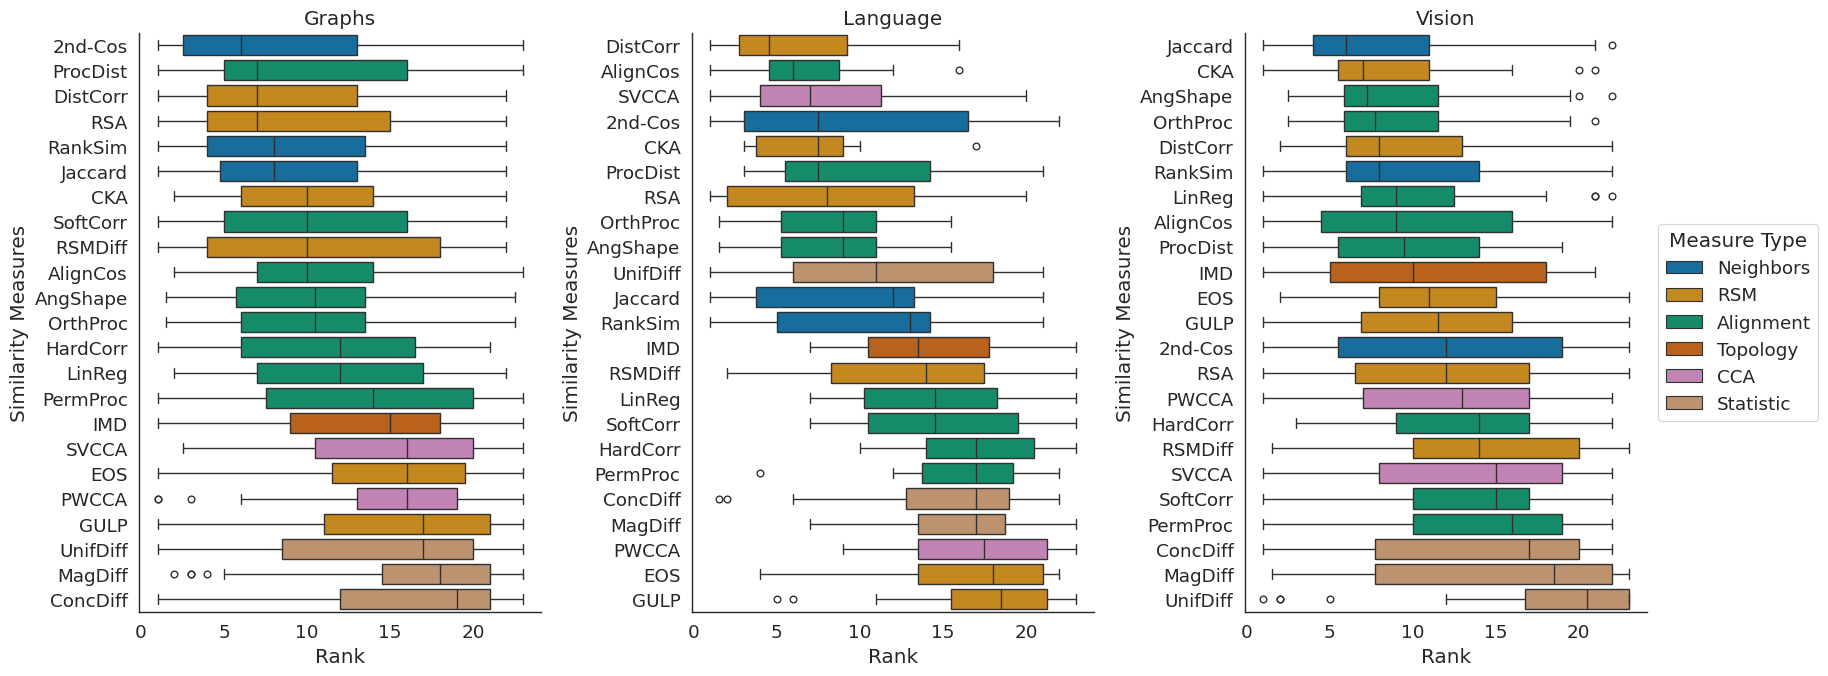

In [74]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
plot_data = pd.merge(plot_data, pd.DataFrame.from_records(measure_types, columns=["Sim Meas.", "Measure Type"]), how="left", on="Sim Meas.")

fig, axes = plt.subplots(1, 3, sharey=False, figsize=(7*0.8*3, 7))
fig

for i, mod in enumerate(["Graph", "Language", "Vision"]):
# for i, mod in enumerate(plot_data.Modality.unique()):
    # g = sns.catplot(
    #     data=plot_data[plot_data.Modality == mod],
    #     x="rank",
    #     y="Sim Meas.",
    #     hue="Measure Type",
    #     # hue="Modality",
    #     kind="box",
    #     height=7,
    #     aspect=0.8,
    #     col="Modality",
    #     palette="colorblind",
    #     # palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
    #     legend=True if mod=="Vision" else False
    #     # legend=False
    # )
    # ax = g.axes[0, 0]

    ax = axes[i]
    sns.boxplot(
        data=plot_data[plot_data.Modality == mod],
        x="rank",
        y="Sim Meas.",
        hue="Measure Type",
        hue_order=["Neighbors", "RSM", "Alignment", "Topology", "CCA", "Statistic"],
        # palette={
        #     "Neighbors": "C0",
        #     "RSM": "C1",
        #     "Alignment": "C2",
        #     "Topology": "C3",
        #     "CCA": "C4",
        #     "Statistic": "C5",
        # },
        palette="colorblind",
        legend=True if mod=="Vision" else False,
        ax=ax
    )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")

    fig.tight_layout()

    if mod == "Graph":
        ax.set_title("Graphs")
    else:
        ax.set_title(mod)

    if mod == "Vision":
        sns.move_legend(ax, loc="right", bbox_to_anchor=(1.45,0.5))
    # g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")
    fig.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

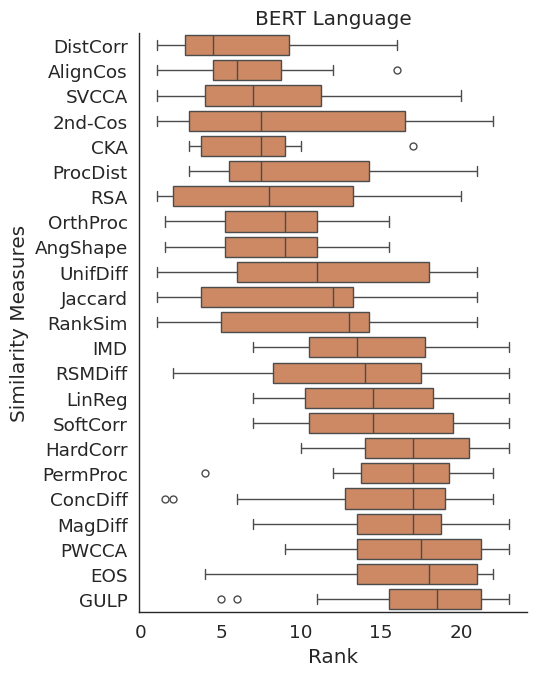

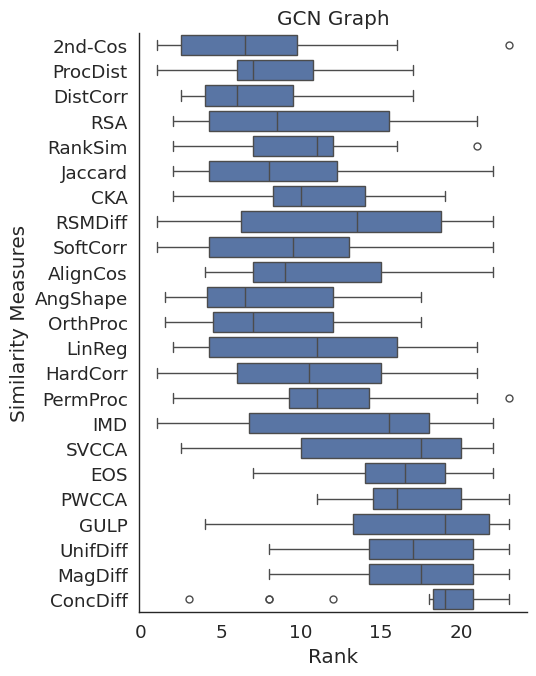

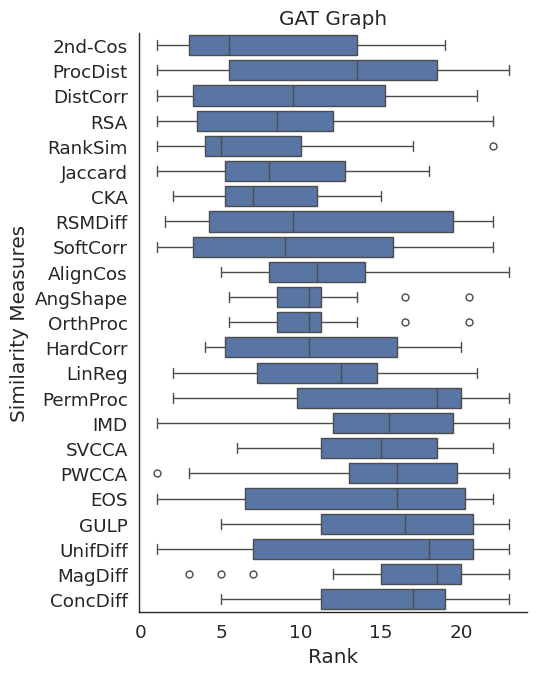

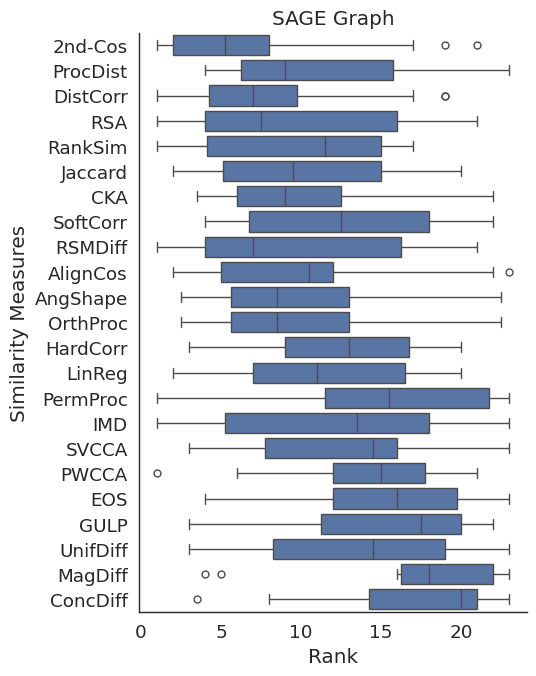

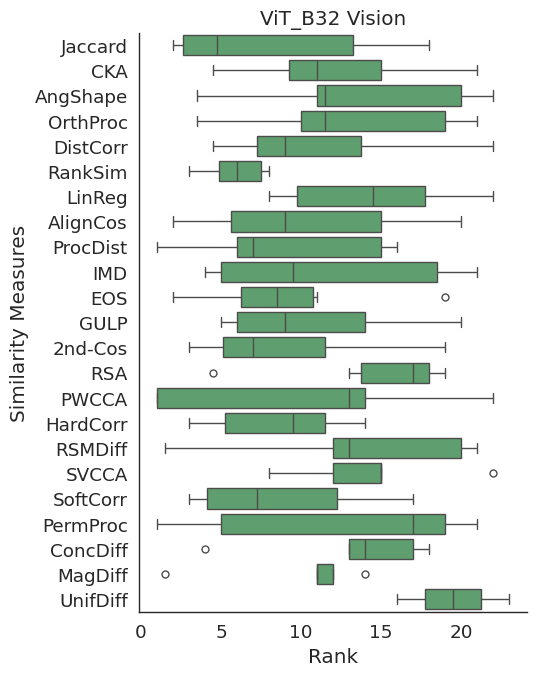

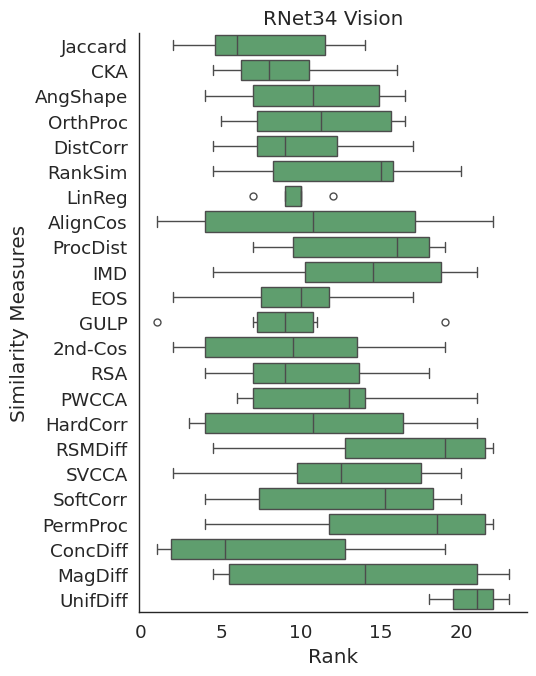

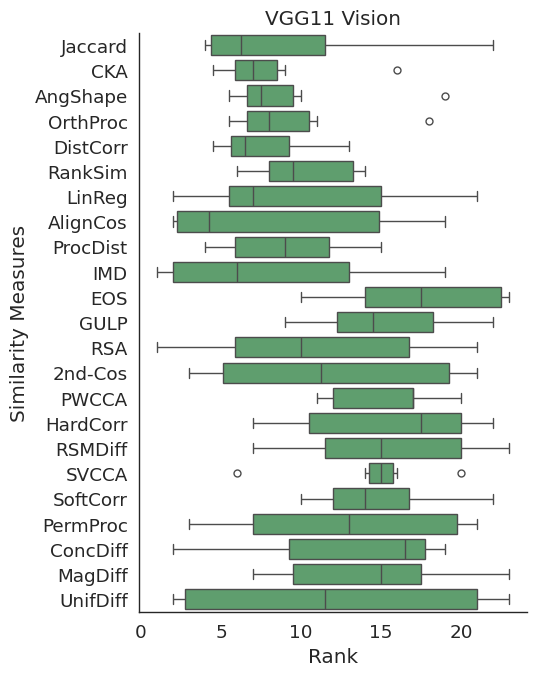

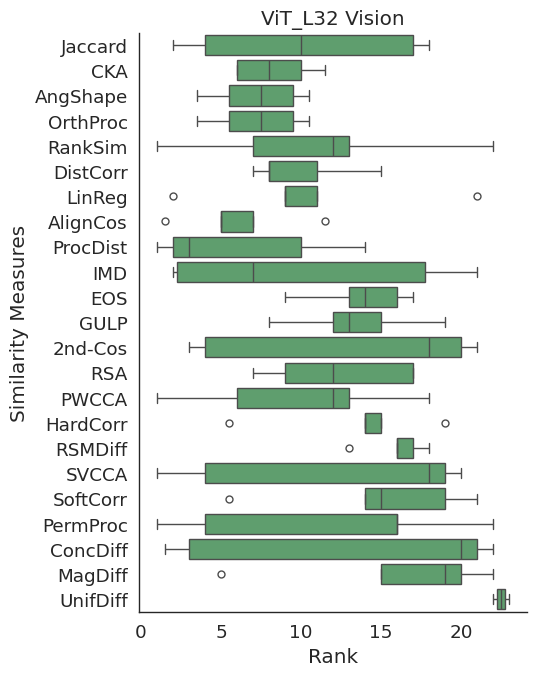

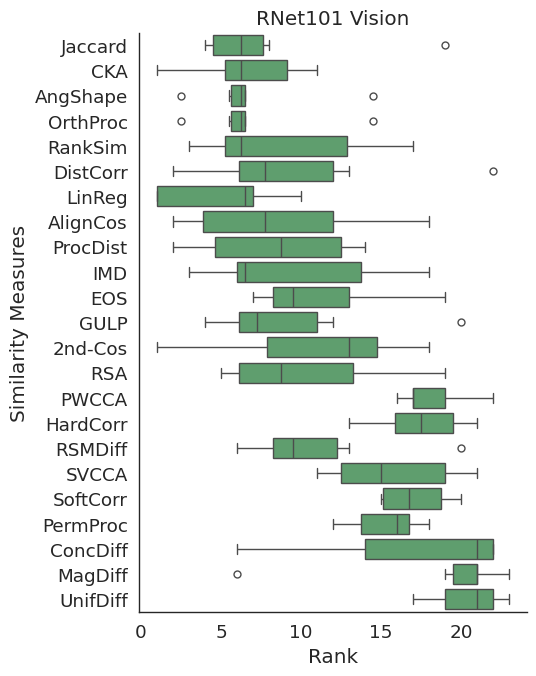

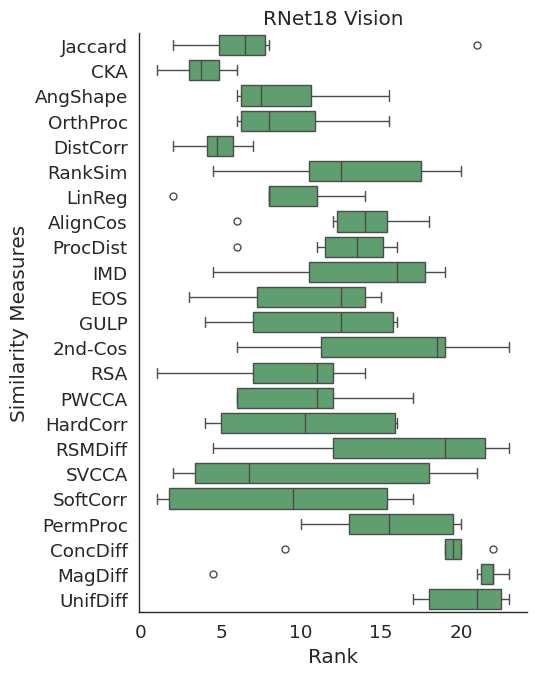

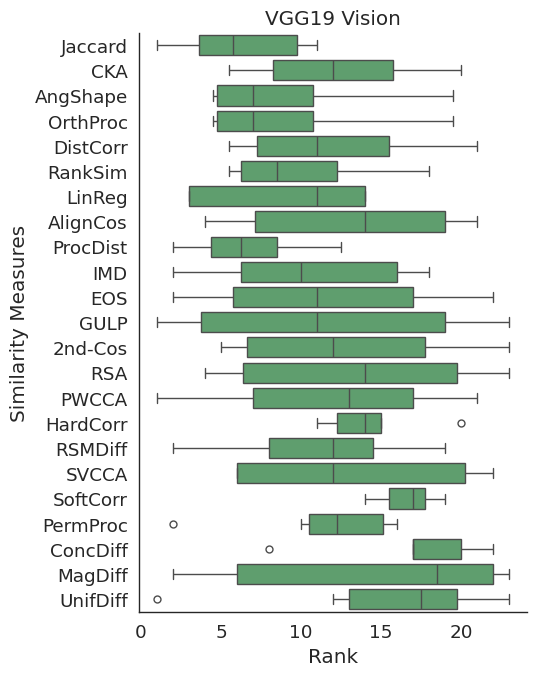

In [15]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for mod in plot_data.Modality.unique():
    for arch in plot_data["Arch."].unique():
        subdata = plot_data[(plot_data.Modality == mod) & (plot_data["Arch."] == arch)]
        if len(subdata) == 0:
            continue

        g = sns.catplot(
            data=plot_data[(plot_data.Modality == mod) & (plot_data["Arch."] == arch)],
            x="rank",
            y="Sim Meas.",
            hue="Modality",
            kind="box",
            height=7,
            aspect=0.8,
            col="Arch.",
            palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
            legend=False
        )
        ax = g.axes[0, 0]
        ax.set_xlabel("Rank")
        ax.set_ylabel("Similarity Measures")

        ax.set_title(f"{arch} {mod}")
        # g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

In [16]:
data["Arch."].unique()

array(['GAT', 'RNet18', nan, 'VGG19', 'GCN', 'BERT', 'SAGE', 'ViT_L32',
       'VGG11', 'RNet34', 'ViT_B32', 'RNet101'], dtype=object)

/root/similaritybench/experiments/figs/aggregated_ver_VGGs.pdf
/root/similaritybench/experiments/figs/aggregated_ver_ResNets.pdf


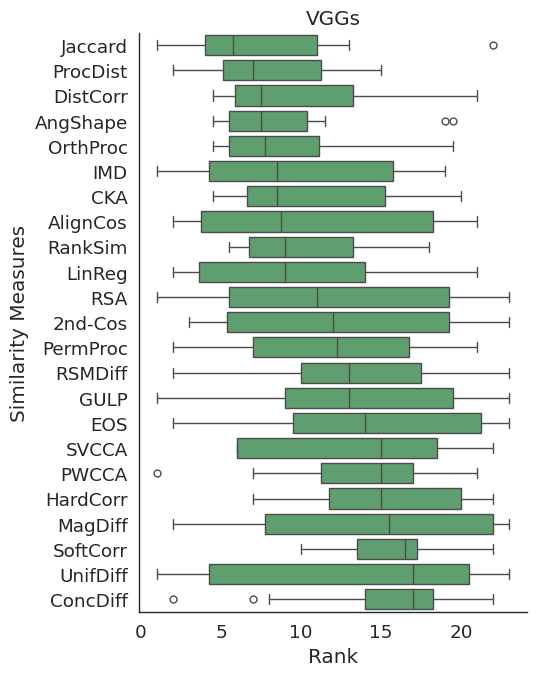

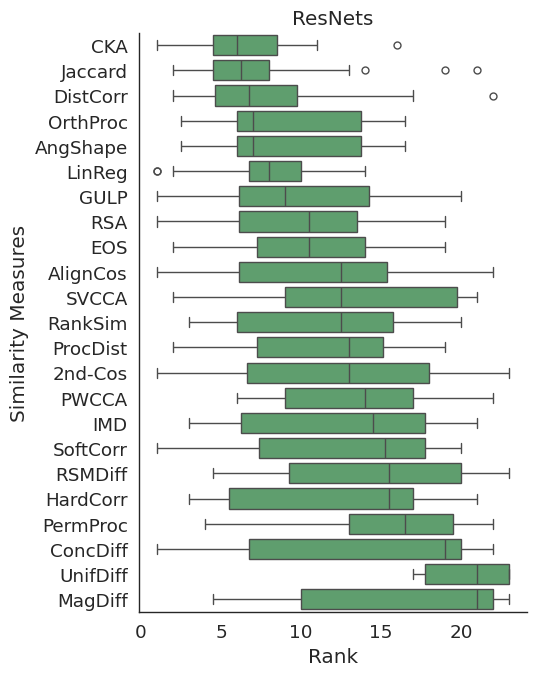

In [17]:
for archs, fname in [
    (["VGG11", "VGG19"], "VGGs"),
    (["RNet18", "RNet34", "RNet101"], "ResNets")
    ]:
    avg_ranks = data[(data["Arch."].isin(archs))].groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
    # avg_ranks = data[data["Arch."].isin(archs)].groupby(["Modality", "Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
    avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
    avg_ranks

    plot_data = pd.merge(data, avg_ranks).sort_values(by="med_rank")
    subdata = plot_data[(plot_data.Modality == "Vision") & (plot_data["Arch."].isin(archs))]

    g = sns.catplot(
        data=subdata,
        x="rank",
        y="Sim Meas.",
        hue="Modality",
        kind="box",
        height=7,
        aspect=0.8,
        col="Modality",
        palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        legend=False
    )
    ax = g.axes[0, 0]
    ax.set_xlabel("Rank")
    ax.set_ylabel("Similarity Measures")

    ax.set_title(f"{fname}")
    g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{fname}.pdf", bbox_inches="tight")
    print(BASE_PATH / "figs" / f"aggregated_ver_{fname}.pdf")

### Per Test

Uses only the AUPRC und spearman results

In [18]:
print(data["Eval."].unique())
data.head()

['Spearman' 'AUPRC']


,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank
5999,4849,2nd-Cos,Spearman,1.000000,Graph,GAT,ogbn-arxiv,MultiLayer,Layer Mono.,arXiv,NaN,NaN,NaN,GRAPHS_GAT_ogbn-arxiv_MultiLayer_0,NaN
4439,3289,2nd-Cos,AUPRC,0.732973,Graph,GAT,cora,Normal,Random Labels,Cora,NaN,NaN,NaN,agg,3.0
8464,1564,2nd-Cos,AUPRC,0.783254,Vision,RNet18,Gauss_Off_ImageNet100DataModule,GaussNoise,Augmentation,IN100,NaN,NaN,NaN,agg,9.0
4485,3335,2nd-Cos,AUPRC,0.214944,Graph,NaN,cora,Normal,Random Labels,Cora,NaN,NaN,NaN,agg,20.0
8418,1518,2nd-Cos,AUPRC,0.803319,Vision,VGG19,Gauss_Off_ImageNet100DataModule,GaussNoise,Augmentation,IN100,NaN,NaN,NaN,agg,5.0


In [19]:
avg_ranks = data.groupby(["Modality", "Sim Meas.", "Scenario"])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

,Modality,Sim Meas.,Scenario,avg_rank,med_rank
0,Graph,2nd-Cos,Acc Corr.,11.200000,8.5
1,Graph,2nd-Cos,Augmentation,3.888889,3.0
2,Graph,2nd-Cos,Disagr. Corr.,10.700000,8.5
3,Graph,2nd-Cos,JSD Corr.,9.600000,9.0
4,Graph,2nd-Cos,Layer Mono.,NaN,NaN
...,...,...,...,...,...
478,Vision,UnifDiff,Disagr. Corr.,6.666667,2.0
479,Vision,UnifDiff,JSD Corr.,15.000000,19.0
480,Vision,UnifDiff,Layer Mono.,NaN,NaN
481,Vision,UnifDiff,Random Labels,19.285714,21.0


In [20]:
from IPython.display import display

In [21]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
for test in plot_data.Scenario.unique():
    for mod in plot_data.Modality.unique():
        subplot_data = plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)]
        # --------------------------- V1 ---------------------------------------
        # g = sns.catplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     kind="swarm",
        #     height=7,
        #     aspect=0.8,
        #     col="Modality",
        #     palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        #     legend=False
        # )

        # --------------------------- V2 ---------------------------------------
        # fig, ax = plt.subplots(1, 1, figsize=(7, 7*0.8))
        # g = sns.boxplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     # height=7,
        #     # aspect=0.8,
        #     # col="Modality",
        #     palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
        #     # legend=False,
        #     ax=ax
        # )
        # g = sns.stripplot(
        #     data=plot_data[(plot_data.Scenario == test) & (plot_data.Modality == mod)],
        #     x="rank",
        #     y="Sim Meas.",
        #     hue="Modality",
        #     size=5,
        #     # height=7,
        #     # aspect=0.8,
        #     # col="Modality",
        #     palette={"Language": "C2", "Vision": "C3", "Graph": "C1"},
        #     # legend=False,
        #     ax=ax
        # )
        # ------------------------------------------------------------------------

        # # ax = g.axes[0, 0]
        # for i in range(len(subplot_data["Sim Meas."].unique())):
        #     if i % 2 == 0:
        #         ax.fill_between([0, 23], [-0.5 + i, -0.5 + i], [0.5 + i, 0.5 + i], color="gray", alpha=0.2)
        # ax.set_xlabel("Rank")
        # ax.set_ylabel("Similarity Measures")
        # if mod == "Graph":
        #     ax.set_title(f"{test} (Graphs)")
        # else:
        #     ax.set_title(f"{test} ({mod})")
        # g.savefig(BASE_PATH / "figs" / f"aggregated_ver_{mod}.pdf", bbox_inches="tight")

        display(subplot_data.head(2))

        break
    break

,index,Sim Meas.,Eval.,value,Modality,Arch.,representation_dataset,identifier,Scenario,Dataset,Functional Similarity Measure,corr,pval,model,rank,avg_rank,med_rank
222,600,AlignCos,AUPRC,0.994444,Language,BERT,sst2_mem_rate0,RandomLabels_75,Random Labels,SST2,NaN,NaN,NaN,agg,1.0,1.25,1.25
238,71,AlignCos,AUPRC,1.000000,Language,BERT,mnli_mem_rate0,RandomLabels_75,Random Labels,MNLI,NaN,NaN,NaN,agg,1.5,1.25,1.25


In [22]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
plot_data.loc[plot_data.Scenario.isin(["Acc Corr.", "JSD Corr.", "Disagr. Corr."]), "Type"] = "Grounding by Prediction"
plot_data.loc[plot_data.Scenario.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
column_order = ["Acc Corr.", "JSD Corr.", "Disagr. Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]

# -------------------------------------------
# Create pivot with mean values. The values are converted to string for combination with stddev
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values="value",
    aggfunc="mean",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot_mean = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values=1,)
unpivot
pivot_mean

# display(pivot.head())

# -----------------------------------------------
# Create pivot with stddev values.
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values="value",
    aggfunc="std",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot

unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: str(round(x, 2)))
pivot_std = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Scenario", "Eval.", "Modality"],
    values=1,)
unpivot
pivot_std
# display(pivot.head())

# -----------------------------------------
# Combine mean with stddev
pivot_comb = pivot_mean + r"$\pm$" + pivot_std



# -----------------------------------------
# Bold best metric scores
def floatify(s: str) -> str:
    """Turn a string like '-0.10$\pm$0.2' into '-0.10'"""
    return s[:s.find("$")]

def separate_significance_indicator(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '$^{\phantom{**}}$'"""
    return s[s.find("$"):]


for column in pivot_comb.columns:
    col = pivot_comb.loc[:, column].apply(floatify).astype("float").copy()
    stddev = pivot_comb.loc[:, column].apply(separate_significance_indicator)
    idx = col == col.max()
    new_col = col.apply(lambda x: f"{x:.2f}").map(lambda s: r"\textbf{" + s + "}") + stddev.map(lambda s: r"\textbf{" + s + "}")
    pivot_comb.loc[idx, column] = new_col

pivot_comb

Type               Grounding by Prediction                                   \
Scenario                         Acc Corr.                                    
Eval.                             Spearman                                    
Modality                             Graph                         Language   
Sim Meas.                                                                     
2nd-Cos                     -0.01$\pm$0.27                    0.02$\pm$0.39   
AlignCos                    -0.01$\pm$0.23                    0.13$\pm$0.16   
AngShape                     0.02$\pm$0.21                    0.07$\pm$0.29   
CKA                          -0.0$\pm$0.15                    0.06$\pm$0.17   
ConcDiff                    -0.09$\pm$0.14                    0.06$\pm$0.08   
DistCorr                     0.07$\pm$0.22                    0.03$\pm$0.18   
EOS                          -0.06$\pm$0.2                   -0.18$\pm$0.29   
GULP                        -0.14$\pm$0.18                   -0.18$\pm$0.25   
HardCorr                     0.09$\pm$0.19                   -0.14$\pm$0.26   
IMD                         -0.03$\pm$0.16                   -0.16$\pm$0.14   
Jaccard                     -0.04$\pm$0.21                   -0.02$\pm$0.27   
LinReg                      -0.06$\pm$0.13                    -0.1$\pm$0.39   
MagDiff                     -0.03$\pm$0.16                    0.04$\pm$0.25   
OrthProc                     0.02$\pm$0.21                    0.07$\pm$0.29   
PWCCA                        -0.1$\pm$0.13                   -0.16$\pm$0.24   
PermProc                     0.06$\pm$0.22                    -0.0$\pm$0.13   
ProcDist                     0.06$\pm$0.19                    0.19$\pm$0.13   
RSA                           0.1$\pm$0.27                   -0.11$\pm$0.17   
RSMDiff                     -0.05$\pm$0.15  \textbf{0.25}\textbf{$\pm$0.07}   
RankSim                      0.06$\pm$0.23                    0.03$\pm$0.16   
SVCCA                       -0.11$\pm$0.14                    0.12$\pm$0.28   
SoftCorr   \textbf{0.13}\textbf{$\pm$0.16}                   -0.11$\pm$0.31   
UnifDiff                    -0.13$\pm$0.09                    0.24$\pm$0.14   

Type                                                                         \
Scenario                                                          JSD Corr.   
Eval.                                                              Spearman   
Modality                            Vision                            Graph   
Sim Meas.                                                                     
2nd-Cos                     -0.09$\pm$0.14                    0.26$\pm$0.24   
AlignCos                    -0.08$\pm$0.14                     0.15$\pm$0.2   
AngShape                     0.05$\pm$0.12                     0.26$\pm$0.3   
CKA                          0.01$\pm$0.21                    0.19$\pm$0.28   
ConcDiff                     0.02$\pm$0.18                   -0.01$\pm$0.15   
DistCorr                    -0.01$\pm$0.19                    0.25$\pm$0.28   
EOS                          0.05$\pm$0.22                    0.09$\pm$0.21   
GULP                         0.02$\pm$0.14                    0.15$\pm$0.15   
HardCorr                     0.07$\pm$0.17                    0.23$\pm$0.31   
IMD                         -0.06$\pm$0.17                   -0.01$\pm$0.19   
Jaccard                     -0.03$\pm$0.15  \textbf{0.28}\textbf{$\pm$0.17}   
LinReg                        0.06$\pm$0.1                    0.18$\pm$0.29   
MagDiff                     -0.03$\pm$0.11                   -0.02$\pm$0.15   
OrthProc                     0.05$\pm$0.12                     0.26$\pm$0.3   
PWCCA                        0.08$\pm$0.36                    0.07$\pm$0.25   
PermProc                     -0.0$\pm$0.16                    0.03$\pm$0.31   
ProcDist                     0.09$\pm$0.06                    0.03$\pm$0.31   
RSA                         -0.05$\pm$0.19  \text

In [23]:
styled = pd.io.formats.style.Styler(
    pivot_comb,
    precision=2,
)

# Highlight top value
# latex_str = styled.highlight_max(axis=0, props="textbf:--rwrap;").to_latex(
#     hrules=True,
#     position="t",
#     label="tab:result_overview",
# )
latex_str = styled.to_latex(hrules=True, position="t", label="tab:results_agg_per_test",)


# ----- Manual modifications --------
latex_str = latex_str.split("\n")

# # Center headers
# pattern = r"\{r\}"
# replacement = r"{c}"
# latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

# # Remove measure row
# latex_str.pop(11)

# # Add vertical bars
# line_no = 2
# # line_no = 3
# mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
# latex_str[line_no] = mod_line

# Make every second row gray
latex_str = [
    r"\rowcolor{Gray}" + line if i >= 12 and (i - 12) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
] + latex_str[-4:]
latex_str = "\n".join(latex_str)
print(latex_str)

\begin{table}[t]
\label{tab:results_agg_per_test}
\begin{tabular}{llllllllllllllllllllll}
\toprule
Type & \multicolumn{9}{r}{Grounding by Prediction} & \multicolumn{12}{r}{Grounding by Design} \\
Scenario & \multicolumn{3}{r}{Acc Corr.} & \multicolumn{3}{r}{JSD Corr.} & \multicolumn{3}{r}{Disagr. Corr.} & \multicolumn{3}{r}{Random Labels} & \multicolumn{3}{r}{Shortcuts} & \multicolumn{3}{r}{Augmentation} & \multicolumn{3}{r}{Layer Mono.} \\
Eval. & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{Spearman} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{AUPRC} & \multicolumn{3}{r}{Spearman} \\
Modality & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision & Graph & Language & Vision \\
Sim Meas. &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
2nd-Cos & -0.01$\pm$0.27 & 0.02$\pm$0.39 & -0

In [24]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
plot_data.loc[plot_data.Scenario.isin(["Acc Corr.", "JSD Corr.", "Disagr. Corr."]), "Type"] = "Grounding by Prediction"
plot_data.loc[plot_data.Scenario.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
        "Grounding by Design"
    )
column_order = ["Acc Corr.", "JSD Corr.", "Disagr. Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]

# -------------------------------------------
# Create pivot with mean ranks. The values are converted to string for combination with stddev
pivot = pd.pivot_table(
    plot_data,
    index="Sim Meas.",
    columns=["Modality", "Type", "Scenario", "Eval."],
    values="rank",
    aggfunc="mean",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Scenario")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot


Modality                    Graph                           \
Type      Grounding by Prediction                            
Scenario                Acc Corr.  JSD Corr. Disagr. Corr.   
Eval.                    Spearman   Spearman      Spearman   
Sim Meas.                                                    
2nd-Cos                     11.20   9.600000     10.700000   
AlignCos                    11.90  12.600000     13.900000   
AngShape                    10.05   8.150000      8.450000   
CKA                         10.80  10.400000     10.800000   
ConcDiff                    14.50  16.700000     16.800000   
DistCorr                     9.10   9.500000      9.900000   
EOS                         13.40  13.700000     13.700000   
GULP                        15.20  12.400000     13.400000   
HardCorr                     9.50   9.700000      9.500000   
IMD                         12.70  16.800000     16.400000   
Jaccard                     13.90   8.000000      8.500000   
LinReg                      14.60  10.300000     11.300000   
MagDiff                     12.80  16.700000     16.500000   
OrthProc                    10.15   8.250000      8.550000   
PWCCA                       15.00  14.444444     14.111111   
PermProc                    10.30  14.500000     12.300000   
ProcDist                     9.70  13.900000     12.800000   
RSA                          8.40   6.700000      5.400000   
RSMDiff                     11.70  16.800000     14.400000   
RankSim                     11.20   7.900000      9.400000   
SVCCA                       15.60  13.500000     14.300000   
SoftCorr                     6.50   9.200000      9.000000   
UnifDiff                    17.00  15.400000     15.000000   

Modality                                                             Language  \
Type      Grounding by Design                         Grounding by Prediction   
Scenario        Random Labels  Shortcuts Augmentation               Acc Corr.   
Eval.                   AUPRC      AUPRC        AUPRC                Spearman   
Sim Meas.                                                                       
2nd-Cos              8.200000   5.050000     3.888889                    12.0   
AlignCos             9.500000   7.450000    12.000000                     7.0   
AngShape            11.600000   9.200000    11.166667                    10.0   
CKA                  7.950000  10.300000    10.333333                     9.5   
ConcDiff            14.150000  17.900000    18.555556                    12.0   
DistCorr             8.450000   8.000000     7.000000                    11.5   
EOS                 18.800000  14.300000    14.666667                    18.5   
GULP                19.100000  16.400000    16.333333                    20.0   
HardCorr            12.350000  15.200000    13.888889                    17.0   
IMD                  9.100000  12.200000    13.888889                    16.0   
Jaccard             13.400000   5.150000     4.666667                    12.5   
LinReg              12.700000  10.850000    11.555556                    15.5   
MagDiff             16.300000  19.300000    16.555556                    10.5   
OrthProc            11.600000   9.300000    11.166667                    10.0   
PWCCA               17.444444  15.777778    15.428571                    17.5   
PermProc            10.400000  19.100000    13.666667                    12.5   
ProcDist             7.650000   9.500000     8.111111                     5.0   
RSA                 11.900000  10.300000    13.777778                    17.0   
RSMDiff              5.300000  10.150000     5.611111                     2.5   
RankSim             12.200000   5.750000     6.666667                    12.5   
SVCCA               12.400000  17.100000    15.777778                     6.0   
SoftCorr            12.850000  12.900000    14.777778                    15.0   
UnifDiff            12.100000  14.100000    14.833333                     6.

In [25]:
for mod in data.Modality.unique():
    print(mod)
    subdata = pivot.loc[:, mod]
    # display(subdata.head(3))
    styled = pd.io.formats.style.Styler(
        subdata,
        precision=1,
    )

    # Highlight top value
    latex_str = styled.highlight_min(axis=0, props="textbf:--rwrap;").to_latex(
        hrules=True,
        position="t",
        label="tab:result_overview",
    )
    latex_str = styled.to_latex(hrules=True, position="t", label="tab:results_agg_per_test",)


    # ----- Manual modifications --------
    latex_str = latex_str.split("\n")

    # # Center headers
    # pattern = r"\{r\}"
    # replacement = r"{c}"
    # latex_str = [re.sub(pattern, replacement, line) if i in [5, 6, 7] else line for i, line in enumerate(latex_str)]

    # Remove measure row
    latex_str.pop(7)

    # Remove eval measure row
    latex_str.pop(6)

    # # Add vertical bars
    # line_no = 2
    # # line_no = 3
    # mod_line = latex_str[line_no][:17] + "".join(["|rrr"] * 6) + "}"
    # latex_str[line_no] = mod_line

    # Make every second row gray
    latex_str = [
        r"\rowcolor{Gray}" + line if i >= 7 and (i - 7) % 2 == 0 else line for i, line in enumerate(latex_str[:-4])
    ] + latex_str[-4:]
    latex_str = "\n".join(latex_str)
    print(latex_str)

Graph
\begin{table}[t]
\label{tab:results_agg_per_test}
\begin{tabular}{lrrrrrr}
\toprule
Type & \multicolumn{3}{r}{Grounding by Prediction} & \multicolumn{3}{r}{Grounding by Design} \\
Scenario & Acc Corr. & JSD Corr. & Disagr. Corr. & Random Labels & Shortcuts & Augmentation \\
\midrule
\rowcolor{Gray}2nd-Cos & 11.2 & 9.6 & 10.7 & 8.2 & \textbf{5.0} & \textbf{3.9} \\
AlignCos & 11.9 & 12.6 & 13.9 & 9.5 & 7.5 & 12.0 \\
\rowcolor{Gray}AngShape & 10.1 & 8.2 & 8.4 & 11.6 & 9.2 & 11.2 \\
CKA & 10.8 & 10.4 & 10.8 & 8.0 & 10.3 & 10.3 \\
\rowcolor{Gray}ConcDiff & 14.5 & 16.7 & 16.8 & 14.2 & 17.9 & 18.6 \\
DistCorr & 9.1 & 9.5 & 9.9 & 8.4 & 8.0 & 7.0 \\
\rowcolor{Gray}EOS & 13.4 & 13.7 & 13.7 & 18.8 & 14.3 & 14.7 \\
GULP & 15.2 & 12.4 & 13.4 & 19.1 & 16.4 & 16.3 \\
\rowcolor{Gray}HardCorr & 9.5 & 9.7 & 9.5 & 12.3 & 15.2 & 13.9 \\
IMD & 12.7 & 16.8 & 16.4 & 9.1 & 12.2 & 13.9 \\
\rowcolor{Gray}Jaccard & 13.9 & 8.0 & 8.5 & 13.4 & 5.2 & 4.7 \\
LinReg & 14.6 & 10.3 & 11.3 & 12.7 & 10.8 & 11.6 \\
\

tabelle mit ranks als index und entries als metrics

"rank" column: Rank des measures grouped by ["domain", "Setting", "Dataset", "architecture", "model"]

In [26]:
# plot_data = pd.merge(data.copy(), data.groupby(["Modality", "Scenario", "Sim Meas."])["rank"].mean().groupby(["Modality", "Scenario",]).rank().reset_index().rename(columns={"rank": "rank_per_test_and_mod"}))
# display(plot_data)
# plot_data.drop_duplicates(subset=["Modality", "Scenario", "Sim Meas."])

# for mod in data.Modality.unique():
#     subdata = plot_data.loc[plot_data.Modality == mod]
#     pd.pivot(subdata, index="rank_per_test_and_mod", columns=["Scenario"], values="Sim Meas.")
# # data.groupby(["Modality", "Scenario"])["avg_rank"].agg(["mean", "median"]).reset_index()

# # avg_ranks.groupby(["Modality", "Sim Meas.", "Scenario"])["avg_rank"].rank()

## Rebuttal PGNN tables

In [27]:
data = graph_data.copy()

data = data.rename(
    columns={
        "functional_similarity_measure": "Functional Similarity Measure",
        "similarity_measure": "Representational Similarity Measure",
        "quality_measure": "Quality Measure",
    }
)

idx = data.Setting == "correlation"
data.loc[idx, "value"] = data.loc[idx, "corr"]

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "AbsoluteAccDiff")
data.loc[idx, "Setting"] = "acc_corr"

idx = (data.Setting == "correlation") & (data["Functional Similarity Measure"] == "Disagreement")
data.loc[idx, "Setting"] = "disagr_corr"

data.loc[:, "Representational Similarity Measure"] = data["Representational Similarity Measure"].map(
    measure_to_abbrv
)
data.loc[:, "architecture"] = data["architecture"].map(
    {
        "BERT-L": "BERT",
        "GCN": "GCN",
        "GAT": "GAT",
        "GraphSAGE": "SAGE",
        "VGG11": "VGG11",
        "VGG19": "VGG19",
        "ResNet18": "RNet18",
        "ResNet34": "RNet34",
        "ResNet101": "RNet101",
        "ViT_B32": "ViT_B32",
        "ViT_L32": "ViT_L32",
        "PGNN": "P-GNN",
    }
)
data.loc[:, "domain"] = data["domain"].map({"NLP": "Text", "GRAPHS": "Graph", "VISION": "Vision"})
data.loc[:, "Dataset"] = data["Dataset"].map(
    {
        "mnli_aug_rate0": "MNLI",
        "mnli_mem_rate0": "MNLI",
        "mnli": "MNLI",
        "sst2_sc_rate0558": "SST2",
        "sst2_mem_rate0": "SST2",
        "mnli_sc_rate0354": "MNLI",
        "sst2_aug_rate0": "SST2",
        "sst2": "SST2",
        "flickr": "flickr",
        "ogbn-arxiv": "arXiv",
        "cora": "Cora",
        "in100": "IN100",
    }
)
data.loc[:, "Setting"] = data["Setting"].map(
    {
        "aug": "Augmentation",
        "mem": "Random Labels",
        "correlation": "JSD Corr.",
        "acc_corr": "Acc Corr.",
        "disagr_corr": "Disagr. Corr.",
        "mono": "Layer Mono.",
        "sc": "Shortcuts",
    }
)
column_order = ["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]
data.loc[:, "Setting"] = pd.Categorical(
    data["Setting"],
    categories=column_order,
    ordered=True,
)
data.loc[:, "Quality Measure"] = data["Quality Measure"].map(
    {"violation_rate": "Conformity Rate", "AUPRC": "AUPRC", "spearmanr": "Spearman", "correlation": "Spearman"}
)
data.loc[data["Quality Measure"] == "Conformity Rate", "value"] = (
    1 - data.loc[data["Quality Measure"] == "Conformity Rate", "value"]
)  # must be run in conjunction with the above renaming

data = data.rename(
    columns={
        "domain": "Modality",
        "architecture": "Arch.",
        "Representational Similarity Measure": "Sim Meas.",
        "Quality Measure": "Eval.",
        "Setting": "Test",
    }
)
data.loc[data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."]), "Type"] = "Grounding by Prediction"
data.loc[data.Test.isin(["Random Labels", "Shortcuts", "Augmentation", "Layer Mono."]), "Type"] = (
    "Grounding by Design"
)

data = data[(~data["Eval."].isna()) & (data["Dataset"] == "Cora") & (data["Test"].isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr.", "Layer Mono."]))]

pivot = pd.pivot_table(
    data,
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values="value",
)
pivot = pivot.sort_values(by="Sim Meas.")
pivot = pivot.reindex(column_order, axis="columns", level="Test")
pivot = pivot.reindex(["Grounding by Prediction", "Grounding by Design"], axis="columns", level="Type")
pivot = pivot.reindex(["GAT", "GCN", "SAGE", "P-GNN"], axis="columns", level="Arch.")
pivot

# turn vals into string
unpivot = pivot.unstack().reset_index()  # values will be in col "0"
unpivot.loc[:, 1] = unpivot.loc[:, 0].astype("str")
unpivot.loc[:, 1] = unpivot.loc[:, 0].apply(lambda x: f"{round(x, 2):.2f}")
pivot = unpivot.pivot(index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=1,)
unpivot


for column in pivot.columns:
    col = pivot.loc[:, column].astype("float")
    idx = col == col.max()
    pivot.loc[idx, column] = pivot.loc[idx, column].apply(lambda s: r"\textbf{" + s + "}")


# add significance indicators
idx = data["Dataset"].isin(["Cora"]) & data.Test.isin(["Acc Corr.", "Disagr. Corr.", "JSD Corr."])
data_corr = data.loc[idx].copy()


def pval_str(pval):
    # if pval == pd.notna
    if isinstance(pval, float):
        if pval <= 0.01:
            return r"$^{**}$"
            # return r"$^{\dagger}$"
        if pval <= 0.05:
            return r"$^{*\phantom{*}}$"
            # return r"$^{\ddagger}$"
    return r"$^{\phantom{**}}$"

data_corr["val_comb"] = data_corr["value"].apply(lambda x: f"{round(x, ndigits=2):.2f}") + data_corr["pval"].apply(pval_str)
data_corr

pivot_corr = data_corr.drop_duplicates(
    subset=[
        "Sim Meas.",
        "Eval.",
        "model",
        "Modality",
        "Arch.",
        "representation_dataset",
        "identifier",
        "Test",
        "Dataset",
        "Functional Similarity Measure",
        "Type"
        ]).pivot(
    index="Sim Meas.",
    columns=["Type", "Test", "Eval.", "Modality", "Dataset", "Arch."],
    values=["val_comb"],
).sort_values(
    by="Sim Meas."
).reindex(
    column_order, axis="columns", level="Test"
).reindex(
    ["Graph", "Text", "Vision"], axis="columns", level="Modality"
).loc[:, "val_comb"]
display(pivot_corr.head(3))


def floatify(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '-0.10'"""
    return s[:s.find("$")]

def separate_significance_indicator(s: str) -> str:
    """Turn a string like '-0.10$^{\phantom{**}}$' into '$^{\phantom{**}}$'"""
    return s[s.find("$"):]


for column in pivot_corr.columns:
    col = pivot_corr.loc[:, column].apply(floatify).astype("float")
    identifiers = pivot_corr.loc[:, column].apply(separate_significance_indicator)
    idx = col == col.max()
    new_col = col.apply(lambda x: f"{x:.2f}").apply(lambda s: r"\textbf{" + s + "}") + identifiers
    pivot_corr.loc[idx, column] = new_col


pivot.loc[:, ("Grounding by Prediction")] = pivot_corr
pivot

Type      Grounding by Prediction                          \
Test                    Acc Corr.                           
Eval.                    Spearman                           
Modality                    Graph                           
Dataset                      Cora                           
Arch.                         GCN                    SAGE   
Sim Meas.                                                   
2nd-Cos    -0.10$^{\phantom{**}}$   0.04$^{\phantom{**}}$   
AlignCos   -0.33$^{*\phantom{*}}$   0.13$^{\phantom{**}}$   
AngShape    0.15$^{\phantom{**}}$  -0.29$^{\phantom{**}}$   

Type                                                       \
Test                                                        
Eval.                                                       
Modality                                                    
Dataset                                                     
Arch.                         GAT                   P-GNN   
Sim Meas.                                                   
2nd-Cos    -0.11$^{\phantom{**}}$   0.13$^{\phantom{**}}$   
AlignCos   -0.29$^{\phantom{**}}$  -0.08$^{\phantom{**}}$   
AngShape   -0.12$^{\phantom{**}}$  -0.02$^{\phantom{**}}$   

Type                                                      \
Test                Disagr. Corr.                          
Eval.                    Spearman                          
Modality                    Graph                          
Dataset                      Cora                          
Arch.                         GCN                   SAGE   
Sim Meas.                                                  
2nd-Cos               0.40$^{**}$  0.25$^{\phantom{**}}$   
AlignCos   -0.08$^{\phantom{**}}$  0.27$^{\phantom{**}}$   
AngShape              0.62$^{**}$  0.16$^{\phantom{**}}$   

Type                                                      \
Test                                                       
Eval.                                                      
Modality                                                   
Dataset                                                    
Arch.                         GAT                  P-GNN   
Sim Meas.                                                  
2nd-Cos     0.30$^{*\phantom{*}}$  0.02$^{\phantom{**}}$   
AlignCos   -0.05$^{\phantom{**}}$  0.01$^{\phantom{**}}$   
AngShape    0.05$^{\phantom{**}}$  0.20$^{\phantom{**}}$   

Type                                                     \
Test                   JSD Corr.                          
Eval.                   Spearman                          
Modality                   Graph                          
Dataset                     Cora                          
Arch.                        GCN                   SAGE   
Sim Meas.                                                 
2nd-Cos              0.43$^{**}$            0.54$^{**}$   
AlignCos   0.02$^{\phantom{**}}$            0.38$^{**}$   
AngShape             0.70$^{**}$  0.27$^{\phantom{**}}$   

Type                                                      
Test                                                      
Eval.                                                     
Modality                                                  
Dataset                                                   
Arch.                        GAT                   P-GNN  
Sim Meas.                                                 
2nd-Cos              0.53$^{**}$  -0.19$^{\phantom{**}}$  
AlignCos   0.17$^{\phantom{**}}$  -0.15$^{\phantom{**}}$  
AngShape   0.28$^{\phantom{**}}$  -0.15$^{\phantom{**}}$

Type              Grounding by Prediction                                  \
Test                            Acc Corr.                                   
Eval.                            Spearman                                   
Modality                            Graph                                   
Dataset                              Cora                                   
Arch.                                 GAT                             GCN   
Sim Meas.                                                                   
2nd-Cos            -0.11$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   
AlignCos           -0.29$^{\phantom{**}}$          -0.33$^{*\phantom{*}}$   
AngShape           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
CKA                 0.02$^{\phantom{**}}$           0.16$^{\phantom{**}}$   
ConcDiff           -0.20$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
DistCorr            0.03$^{\phantom{**}}$           0.01$^{\phantom{**}}$   
EOS                -0.05$^{\phantom{**}}$          -0.24$^{\phantom{**}}$   
GULP               -0.12$^{\phantom{**}}$                    -0.43$^{**}$   
HardCorr           -0.14$^{\phantom{**}}$           0.11$^{\phantom{**}}$   
IMD                -0.03$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   
Jaccard            -0.16$^{\phantom{**}}$           0.02$^{\phantom{**}}$   
LinReg             -0.11$^{\phantom{**}}$           0.06$^{\phantom{**}}$   
MagDiff            -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
OrthProc           -0.12$^{\phantom{**}}$           0.15$^{\phantom{**}}$   
PWCCA              -0.26$^{*\phantom{*}}$          -0.05$^{\phantom{**}}$   
PermProc           -0.26$^{\phantom{**}}$          -0.12$^{\phantom{**}}$   
ProcDist           -0.19$^{\phantom{**}}$           0.08$^{\phantom{**}}$   
RSA                -0.28$^{\phantom{**}}$          -0.27$^{\phantom{**}}$   
RSMDiff            -0.14$^{\phantom{**}}$          -0.19$^{\phantom{**}}$   
RankSim    \textbf{0.32}$^{*\phantom{*}}$          -0.00$^{\phantom{**}}$   
SVCCA              -0.19$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
SoftCorr            0.03$^{\phantom{**}}$  \textbf{0.18}$^{\phantom{**}}$   
UnifDiff           -0.09$^{\phantom{**}}$          -0.10$^{\phantom{**}}$   

Type                                                                       \
Test                                                                        
Eval.                                                                       
Modality                                                                    
Dataset                                                                     
Arch.                                SAGE                           P-GNN   
Sim Meas.                                                                   
2nd-Cos             0.04$^{\phantom{**}}$           0.13$^{\phantom{**}}$   
AlignCos            0.13$^{\phantom{**}}$          -0.08$^{\phantom{**}}$   
AngShape           -0.29$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
CKA                -0.17$^{\phantom{**}}$          -0.08$^{\phantom{**}}$   
ConcDiff           -0.25$^{\phantom{**}}$           0.13$^{\phantom{**}}$   
DistCorr           -0.17$^{\phantom{**}}$           0.17$^{\phantom{**}}$   
EOS                 0.08$^{\phantom{**}}$          -0.04$^{\phantom{**}}$   
GULP                0.08$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
HardCorr           -0.11$^{\phantom{**}}$          -0.12$^{\phantom{**}}$   
IMD                 0.00$^{\phantom{**}}$           0.04$^{\phantom{**}}$   
Jaccard            -0.11$^{\phantom{**}}$           0.07$^{\phantom{**}}$   
LinReg             -0.21$^{*\phantom{*}}$          -0.14$^{\phantom{**}}$   
MagDiff            -0.13$^{\phantom{**}}$           0.18$^{\phantom{**}}$   
OrthProc           -0.29$^{\phantom{**}}$          -0.02$^{\phantom{**}}$   
PWCCA               0.07$^{\phantom{**}}$          -0.09$^{\phantom{**}}

In [28]:
len(data_corr), len(data_corr.drop_duplicates(subset=["Sim Meas.", "Eval.", "model", "Modality", "Arch.", "representation_dataset", "identifier", "Test", "Dataset", "Functional Similarity Measure", "Type"]))
# data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."]).count()[(data_corr.drop_duplicates().groupby(["Arch.", "Dataset", "Eval.", "Test", "Sim Meas."])["value"].count() > 1)]

# data_corr[(data_corr["Sim Meas."] == "IMD") & (data_corr["Dataset"] == "Cora") & (data_corr["Arch."] == "GAT") & (data_corr["Test"] == "JSD Corr.")]

latex_str = pivot.to_latex()
print(latex_str)

\begin{tabular}{lllllllllllllllllllll}
\toprule
Type & \multicolumn{12}{r}{Grounding by Prediction} & \multicolumn{8}{r}{Grounding by Design} \\
Test & \multicolumn{4}{r}{Acc Corr.} & \multicolumn{4}{r}{Disagr. Corr.} & \multicolumn{4}{r}{JSD Corr.} & \multicolumn{8}{r}{Layer Mono.} \\
Eval. & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Spearman} & \multicolumn{4}{r}{Conformity Rate} & \multicolumn{4}{r}{Spearman} \\
Modality & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} & \multicolumn{4}{r}{Graph} \\
Dataset & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} & \multicolumn{4}{r}{Cora} \\
Arch. & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN & GAT & GCN & SAGE & P-GNN \\
Sim Meas. &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
2nd-Cos & -0.11$^{

## Survey Paper Summary

In [29]:
data

,Sim Meas.,Eval.,model,value,Modality,Arch.,representation_dataset,identifier,Test,Dataset,Functional Similarity Measure,corr,pval,Type
691,PWCCA,Spearman,NaN,0.080123,Graph,GCN,cora,Normal,JSD Corr.,Cora,JSD,0.080123,0.4582,Grounding by Prediction
694,PWCCA,Spearman,NaN,0.081399,Graph,GCN,cora,Normal,Disagr. Corr.,Cora,Disagreement,0.081399,0.4274,Grounding by Prediction
697,PWCCA,Spearman,NaN,-0.050123,Graph,GCN,cora,Normal,Acc Corr.,Cora,AbsoluteAccDiff,-0.050123,0.6436,Grounding by Prediction
700,SVCCA,Spearman,NaN,-0.085375,Graph,GCN,cora,Normal,JSD Corr.,Cora,JSD,-0.085375,0.5704,Grounding by Prediction
703,SVCCA,Spearman,NaN,-0.057066,Graph,GCN,cora,Normal,Disagr. Corr.,Cora,Disagreement,-0.057066,0.7098,Grounding by Prediction
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4273,CKA,Spearman,GRAPHS_PGNN_cora_MultiLayer_2,1.000000,Graph,P-GNN,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,Grounding by Design
4274,CKA,Conformity Rate,GRAPHS_PGNN_cora_MultiLayer_3,1.000000,Graph,P-GNN,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,Grounding by Design
4275,CKA,Spearman,GRAPHS_PGNN_cora_MultiLayer_3,1.000000,Graph,P-GNN,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,Grounding by Design
4276,CKA,Conformity Rate,GRAPHS_PGNN_cora_MultiLayer_4,1.000000,Graph,P-GNN,cora,MultiLayer,Layer Mono.,Cora,NaN,NaN,NaN,Grounding by Design


In [30]:
avg_ranks = data.groupby(["Scenario","Sim Meas."])["rank"].agg(["mean", "median"]).reset_index()
avg_ranks = avg_ranks.rename(columns={"mean": "avg_rank", "median": "med_rank"})
avg_ranks

KeyError: 'Scenario'

In [30]:
data.groupby(["Scenario","Sim Meas."])["rank"].max().loc["JSD Corr."]

Sim Meas.
2nd-Cos     23.0
AlignCos    21.0
AngShape    22.0
CKA         21.0
ConcDiff    22.0
DistCorr    17.0
EOS         21.0
GULP        23.0
HardCorr    22.0
IMD         23.0
Jaccard     18.0
LinReg      18.0
MagDiff     22.0
OrthProc    21.0
PWCCA       22.0
PermProc    22.0
ProcDist    22.0
RSA         21.0
RSMDiff     23.0
RankSim     20.0
SVCCA       21.0
SoftCorr    21.0
UnifDiff    22.0
Name: rank, dtype: float64

In [31]:
avg_ranks.pivot_table(values="avg_rank", index="Sim Meas.", columns="Scenario")

Scenario,Acc Corr.,Augmentation,Disagr. Corr.,JSD Corr.,Layer Mono.,Random Labels,Shortcuts
Sim Meas.,,,,,,,
2nd-Cos,14.500000,5.166667,10.222222,10.222222,7.120000,12.333333,4.794118
AlignCos,11.972222,8.666667,11.055556,11.222222,11.972000,9.777778,6.735294
AngShape,11.527778,10.166667,9.583333,8.305556,8.184000,9.777778,7.906250
CKA,10.972222,8.805556,8.944444,9.611111,8.875000,7.416667,8.588235
ConcDiff,13.388889,15.833333,16.944444,17.444444,18.676000,9.388889,18.937500
DistCorr,11.222222,7.972222,8.333333,8.277778,8.560484,7.416667,8.117647
EOS,9.111111,12.055556,14.055556,12.166667,5.700000,17.500000,13.176471
GULP,10.944444,12.666667,14.222222,11.833333,10.404000,18.555556,14.406250
HardCorr,11.055556,15.444444,11.722222,11.666667,12.112000,11.916667,14.205882


In [32]:
avg_ranks.to_csv("ranks_per_test.csv")

Text(-47.83055555555555, 0.5, 'Similarity Measures')

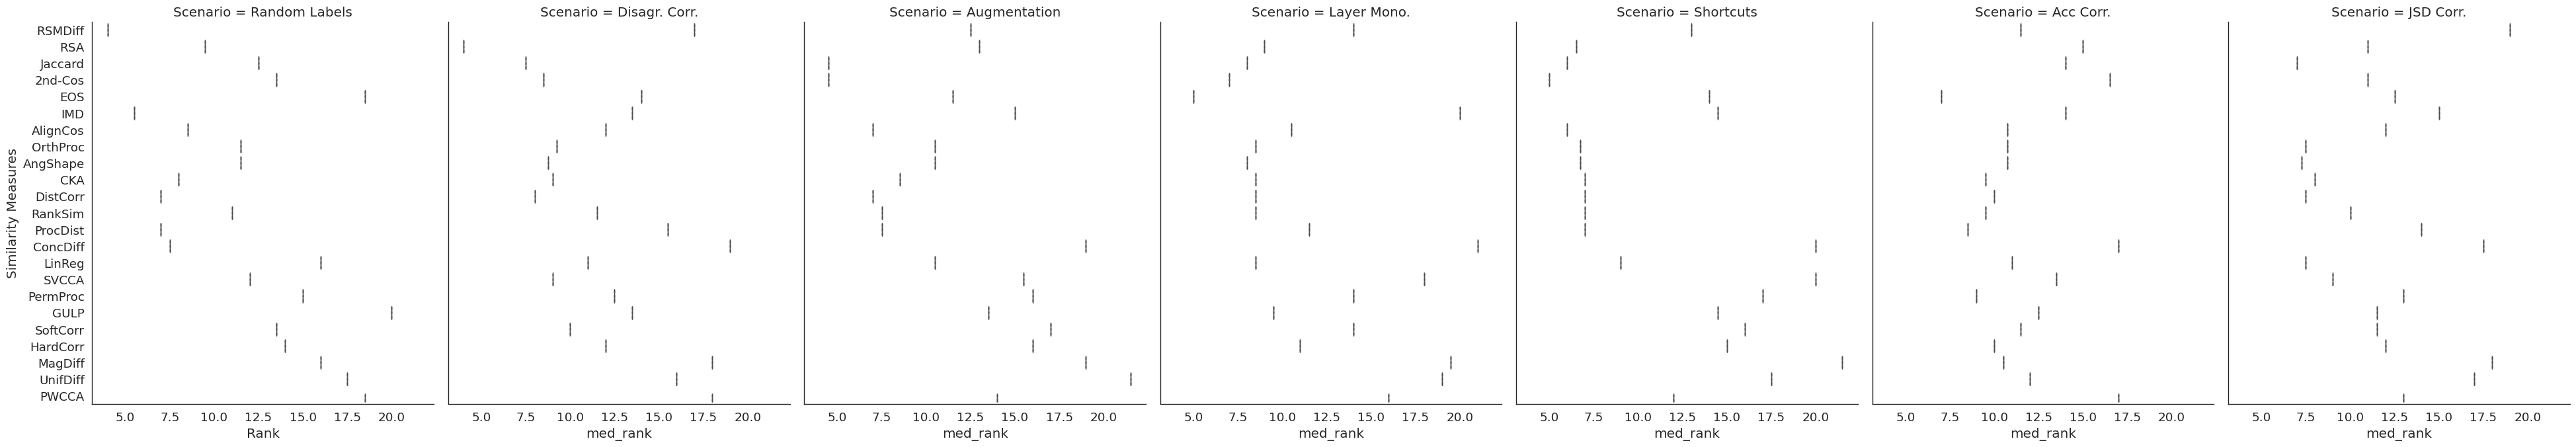

In [33]:
plot_data = pd.merge(data, avg_ranks).sort_values(by=["med_rank"])
g = sns.catplot(
    data=plot_data,
    x="med_rank",
    y="Sim Meas.",
    hue="Modality",
    kind="box",
    height=7,
    aspect=0.8,
    col="Scenario",
    palette={"Language": "C1", "Vision": "C2", "Graph": "C0"},
    legend=False
)
ax = g.axes[0, 0]
ax.set_xlabel("Rank")
ax.set_ylabel("Similarity Measures")